In [53]:
import scipy.linalg as la
import numpy as np
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix
import pandas as pd 
from functools import reduce
import seaborn as sns
from sklearn.decomposition import SparsePCA
import numba
from numba import jit

# Optimization and Demonstration of Biclustering using Sparse Singular Value Decomposition

#### Group members: 

Chengxin Yang: algorithm coding, algorithm optimization, algorithm comparison, simulated data implementation, real data set application

Guanqi Zeng: background, abstract, writing up report, description of algorithm, algorithm coding, preparing the git repository

#### GitHub link and installation instructions

The github repository is on https://github.com/GuanqizEng/STA663-final-biclustering

Please install it by the commend: 

**pip install git+https://github.com/GuanqizEng/STA663-final-biclustering.git@main**.

## Abstract

Biclustering is a method to simultaneously find highly associated sets of rows and columns for high-dimension data. Particularly, for high-dimension low sample size (HDLSS) data, we use biclustering to identify the checkerboard patterns. Sparse singular value decomposition is a new tool for biclustering. It adds the sparsity-inducing penalty to obtain sparse left and right singular vectors. Adaptive lasso penalty is chosen for this paper. The SSVD algorithm is then optimized by numba. After applying SSVD on one simulated data set and two real data sets, we compare its performane to standard SVD and sparse PCA (SPCA).

keywords: HDLSS, checkerboard patterns, Singular Value Decomposition, sparsity-inducing penalty, SPCA

## Background

We chose Biclustering via Sparse Singular Value Decomposition by Mihee Lee, Haipeng Shen, Jianhua Z. Huang, and J. S. Marron published in 2010. This paper provides a new tool, sparse singular value decomposition, for biclustering. Basically, biclustering aims at identifying simultaneously the sets of rows and sets of columns that are significantly associated. The checkerboard patterns found by biclusteirng can better help us to interpret the structure of high-dimension data sets, especially HDLSS data sets. 

The application of biclustering SSVD covers a wide realm. It can be applied to microarray gene expressions to recognize subclusters of particular types of cancer while identify the subjects at the same time. It can also be applied to text categorization to further explore the relationship between texts. In medical imaging, biclustering can help recognize benign and malicious breast tumors through sonographic breast images.

Compared to other SVD-based biclustering tools, such as RoBiC, Plaid, SVD, and SPCA, SSVD has a much better performace in classification. However, the iterative method makes SSVD time-consuimg. In this paper, we used some approaches to improve its speed.

In this research, we clarify and implement the algorithm of SSVD. Then, we perform optimizations and apply the algorithm on a lung cancer data and a breast cancerdata set to test the performance. We also compare its performance to SVD and sparse PCA.

## Description of Algorithm

The key idea of the algorithm is to extend singular value decomposition with sparsity-inducing penalty to find the best lower-rank matrix approximation with sparse singular vectors. In the paper, the sparsity-inducing penalty refers to the adaptive lasso penalty with data-driven weights. As we need to find the sparse vectors $\boldsymbol u$ and $\boldsymbol v$, we put penalty parameters and penalties on both of them. We use BIC to find the optimal penalty parameters.

To illustrate, the need to minimize 
$$||\mathbf X - s \boldsymbol u \boldsymbol v^{T}||^2_{F} + s \lambda_{u} \sum^{n}_{i = 1} w_{1,i} |u_{i}| + s \lambda_{v} \sum^{d}_{j = 1} w_{2,j} |v_{j}|$$

where:
$\mathbf X$ denotes the data matrix, 
$s$ is a positive scalar, 
$\boldsymbol u$ is a unit n-vector,
$\boldsymbol v$ is a unit d-vector,
$w_{1}$ and $w_{2}$ are data-driven weights,
$\lambda_{u}$ and $\lambda_{v}$ are lasso penalty parameters calculated by BIC respectively.

To illustrate the process of finding $\lambda_{u}$ and $\lambda_{v}$, 
$$BIC(\lambda_v) = \frac{||\boldsymbol Y - \hat{\boldsymbol Y}||^2}{nd \cdot \hat{\sigma}^2} + \frac{log(nd)}{nd}\hat{df}(\lambda_{v})$$

$$BIC(\lambda_u) = \frac{||\boldsymbol Z - \hat{\boldsymbol Z}||^2}{nd \cdot \hat{\sigma}^2} + \frac{log(nd)}{nd}\hat{df}(\lambda_{u})$$

where $\hat{df}(\lambda_{v})$ and $\hat{df}(\lambda_{u})$ are the degrees of sparsity of $\boldsymbol v$ and $\boldsymbol u$ respectively with penalty parameters $\lambda v$ and $\lambda u$. The degree of sparsity is the number of zero's in sparse singular vector. We choose $\lambda_{u}$ and $\lambda_{v}$ that minimize $BIC(\lambda_u)$ and $BIC(\lambda_v)$. $\boldsymbol Y = (\mathbf x_{1}^{T},..., \mathbf x_{d}^{T})^{T} \in R^{nd}$ where $\mathbf x_{j} represents the jth column of \boldsymbol X$, and $\boldsymbol Z = (\mathbf x_{(1)}^{T},..., \mathbf x_{(n)}^{T})^{T} \in R^{nd}$ where $\mathbf x_{i} represents the ith row of \boldsymbol X$. Their estimates are the low-rank approximations.

Finally, we illustrate the iterative SSVD algorithm. The demonstration here is for rank-one matrix approximation.

Step 1: 
Initialize $s, \boldsymbol u, \boldsymbol v$ with standard SVD to $\boldsymbol X$, denote them as $s_{old}, \boldsymbol u_{old}, \boldsymbol v_{old}$

Step 2: 
(a)Update $\boldsymbol v_{new}$

Find $\lambda_{v}$. Calculate $\boldsymbol{\tilde{v}}$ where $\tilde{v_{j}} = sign\{(\boldsymbol X^{T} \boldsymbol u_{old})_{j}\}(|(\boldsymbol X^{T} \boldsymbol u_{old})_{j}| - \lambda_{v}w_{2,j}/2)_{+}$. Set $s = \|\boldsymbol{ \tilde {v}}\|$. 

Then, $\boldsymbol{ v_{new}} = \boldsymbol{ \tilde {v}}$.

(b)Update $\boldsymbol u_{new}$

Find $\lambda_{u}$. Calculate $\boldsymbol{\tilde{u}}$ where $\tilde{u_{i}} = sign\{(\boldsymbol X^{T} \boldsymbol v_{new})_{i}\}(|(\boldsymbol X^{T} \boldsymbol v_{new})_{i}| - \lambda_{u}w_{1,i}/2)_{+}$. Set $s = \|\boldsymbol{ \tilde {u}}\|$. 

Then, $\boldsymbol{ u_{new}} = \boldsymbol{ \tilde {u}}$. Set $\boldsymbol{ u_{old}} = \boldsymbol{ u_{new}}$.

(c)Repeat (a) and (b) until the norm between the current $\boldsymbol v_{new}$ and last $\boldsymbol v_{new}$ and that between the current $\boldsymbol u_{new}$ and last $\boldsymbol u_{new}$ are smaller than tolerance.

Step 3:

Set $\boldsymbol u = \boldsymbol u_{new}$, $\boldsymbol v = \boldsymbol v_{new}$, $s = \boldsymbol u^{T}_{new} \boldsymbol X \boldsymbol v_{new}$.

## Implementation and Optimization for Performance

In this section, we implement an improved version of the algorithm in the paper, and then speed it up by numba.

### Implementation with improvments

First, we implement the basic algorithm. Besides coding according to the description in the paper, we improve some calculations to make it run faster.

There are three things we modified to reduce the time consumption. 

First, instead of using the Kronecker product for unpenalized residual, we used trace that gives the same result with a faster speed. To illustrate, for calculating $\|\boldsymbol{Y} - (\boldsymbol{I}_d \bigotimes \boldsymbol{ u}) \tilde{\boldsymbol v} \|^2$, we replace the fitted value by $\text{trace}((\boldsymbol{X} - \boldsymbol{u} \tilde {\boldsymbol{v} ^{T}})(\boldsymbol{X} - \boldsymbol{u} \tilde {\boldsymbol{v}^{T}})^{T})$. Similarly, we replace $\|\boldsymbol{Z} - (\boldsymbol{I}_n \bigotimes \boldsymbol{ v}) \tilde{\boldsymbol u} \|^2$ by $\text{trace}((\boldsymbol{X} - \tilde {\boldsymbol{u}} \boldsymbol{v ^{T}})(\boldsymbol{X} - \tilde{\boldsymbol{u}} \boldsymbol{v ^{T}})^{T})$.

Second, for calculating BIC, we use trace to obtain $\hat \sigma^2$, which is the estimate of the error variane from the model. To illustrate, $\hat{\sigma}_2 = \text{trace}((\boldsymbol{X} - s \boldsymbol{u}\boldsymbol{v})(\boldsymbol{X} - s \boldsymbol{u}\boldsymbol{v})^{T})/(nd-d)$.

Third, for the range of $\lambda_v$ and $\lambda_u$, the original algorithm chooses a grid with static values. However, we notice that we can write $2 (\mathbf X^{T} \boldsymbol u)/ w_{2} > \lambda_v$ and $2 (\mathbf X^{T} \boldsymbol v)/ w_{1} > \lambda_u$. For each iteration of finding the minimum $BIC(\lambda_u)$ and $BIC(\lambda_v)$, $\boldsymbol u$ and $\boldsymbol v$ are constant. Therefore, with the inequalities, it makes sense to adjust the range of possible $\lambda_v$ and $\lambda_u$, so that we do not need to calculate BIC with unnecessary $\lambda$ values. Therefore, we take a dynamic range of values for the penalty parameters according to the value of $2 (\mathbf X^{T} \boldsymbol u)/ w_{2} > \lambda_v$ and $2  (\mathbf X^{T} \boldsymbol v)/ w_{1} > \lambda_u$.

In [60]:
def BICv(X, u, v_tilde, sigma2_hat_v, n, d): #it's the nd times of the original bic
    """
    This function return the n*d times of the original BIC.
    Only used for internal use for the SSVD function.
    It's used when updating v.
    """
    #df = np.sum(np.abs(X.T @ u) > lamd*w/2)
    df = np.sum(np.abs(v_tilde) > 1e-08)
    bic_nd = np.sum((X - u @ v_tilde.T)**2) / (sigma2_hat_v) + np.log(n*d) * df
    #uvt = u @ v_tilde.T
    #bic_nd = np.trace((X - uvt) @ (X - uvt).T) / (sigma2_hat_v) + np.log(n*d) * df
    return bic_nd

def BICu(X, v, u_tilde, sigma2_hat_u, n, d):
    """
    This function return the n*d times of the original BIC.
    Only used for internal use for the SSVD function.
    It's used when updating u.
    """
    df = np.sum(np.abs(u_tilde) > 1e-08)
    #df = np.sum(np.abs(XU) > lamd*omega/2)
    bic_nd = np.sum((X - u_tilde @ v.T)**2) / (sigma2_hat_u) + np.log(n*d) * df
    #uvt = u_tilde @ v.T
    #bic_nd = np.trace((X - uvt) @ (X - uvt).T) / (sigma2_hat_u) + np.log(n*d) * df
    return bic_nd

def opt_lambda_v(X, lamd_grid, Xu_nonzero, w2_nonzero, u, sigma2_hat_v, n, d, index_v):
    """
    This function return best lambda that minimize the correponding BIC.
    Only used for internal use for the SSVD function.
    It's used when updating v.
    """
    
    BICs = np.ones(lamd_grid.shape[0])
    
    for i in range(BICs.shape[0]):
        v_tilde_nonzero = np.sign(Xu_nonzero) * (np.abs(Xu_nonzero) >= lamd_grid[i]*w2_nonzero/2) * (np.abs(Xu_nonzero) - lamd_grid[i]*w2_nonzero/2)
        v_tilde = np.zeros((d,1))
        v_tilde[index_v] = v_tilde_nonzero
        BICs[i] = BICv(X, u, v_tilde, sigma2_hat_v, n, d)
    #BICs = list(map(lambda x: BIC(x, w, u, v_tilde, Y, sigma2_hat_v, n, d), lamd_grid))
    lamd_min = np.argmin(BICs)
    return lamd_grid[lamd_min]

def opt_lambda_u(X, lamd_grid, Xv_nonzero, w1_nonzero, v, sigma2_hat_u, n, d, index_u):
    """
    This function return best lambda that minimize the correponding BIC.
    Only used for internal use for the SSVD function.
    It's used when updating u.
    """
    
    BICs = np.ones(lamd_grid.shape[0])
    
    for i in range(BICs.shape[0]):
        u_tilde_nonzero = np.sign(Xv_nonzero) * (np.abs(Xv_nonzero) >= lamd_grid[i]*w1_nonzero/2) * (np.abs(Xv_nonzero) - lamd_grid[i]*w1_nonzero/2)
        u_tilde = np.zeros((n,1))
        u_tilde[index_u] = u_tilde_nonzero
        BICs[i] = BICu(X, v, u_tilde, sigma2_hat_u, n, d)
    
    #BICs = list(map(lambda x: BIC(x, w, v, u_tilde, Z, sigma2_hat_u, n, d), lamd_grid))
    lamd_min = np.argmin(BICs)
    return lamd_grid[lamd_min]

def uv_renew(u, s, v, X, gamma1, gamma2):
    """
    This function will return the updated u, v and the corresponding lambdas.
    Only for internal use for the SSVD function.
    """
    
    n,d = X.shape
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    SSTO = np.sum(X**2)
    
    ## first, update v
    
    # compute the weights, which are OLS for v (Xu is also the ols)
    Xu = X.T @ u # this is also the v_tilde in the paper, Xu is (d,1)
    w2 = np.abs(Xu)**(-gamma2)
    
    # compute the estimated sigma2 hat for v
    #sigma2_hat_v = np.sum((Y - Yhat)**2) / (n*d - d) 
    uvt = u @ v.T
    sigma2_hat_v = np.trace((X - s*uvt)@(X - s*uvt).T) / (n*d - d) 
    #sigma2_hat_v = np.abs(SSTO - sum(Xu**2)) / (n*d - d) 
    
    # then, find the possible lambdas for v
    # notice that, equivantly, we can write 2 * (X.T @ u) / w2 > lambda_v, and 2 * (X.T @ v) / w1 > lambda_u
    # thus, it makes more sense to search different lambdas according to the values of (X.T @ u)/w2 or (X.T @ v)/w1
    index_v = np.where(w2 < 1e8) # the index where Xu is non-zero. Out of these values, the v will almost be zero.
    index_v = index_v[0]
    Xu_nonzero = Xu[index_v]
    w2_nonzero = w2[index_v]
    lamd_grid_v = 2 * Xu_nonzero / w2_nonzero
    #lamd_grid_v =  Xu[index_v] / w2[index_v]
    lamd_grid_v = np.unique(np.append(0, np.abs(lamd_grid_v)))
    lamd_grid_v.sort()
    lamd_grid_v = lamd_grid_v[0:-1]
    lamd_grid_v = np.r_[lamd_grid_v, np.linspace(0, lamd_grid_v[-1], num = 50)]
    
    # find the optimized lambda for v
    lamd_v = opt_lambda_v(X, lamd_grid_v, Xu_nonzero, w2_nonzero, u, sigma2_hat_v, n, d, index_v)
    
    # update v
    sig_v = np.sign(Xu)
    v_new = sig_v * (np.abs(Xu) - lamd_v*w2/2) * (np.abs(Xu) >= lamd_v*w2/2)
    v_new = v_new / la.norm(v_new)
    
    ## then, update the u
    
    # compute the weights for u
    Xvnew = X @ v_new # this is also the u_tilde in the paper, Xvnew is (n,1)
    w1 = np.abs(Xvnew)**(-gamma1)
    
    # compute the estimated sigma2 hat for u
    uvt = u @ v_new.T
    sigma2_hat_u = np.trace((X - s*uvt)@(X - s*uvt).T) / (n*d - d)
    #sigma2_hat_u = np.abs(SSTO - sum(Xvnew**2)) / (n*d - n) 
    
    # then, find the possible lambdas for u
    index_u = np.where(w1 < 1e8)
    index_u = index_u[0]
    Xv_nonzero = Xvnew[index_u]
    w1_nonzero = w1[index_u]
    lamd_grid_u = 2 * Xv_nonzero / w1_nonzero
    lamd_grid_u = np.unique(np.append(0, np.abs(lamd_grid_u)))
    lamd_grid_u.sort()
    lamd_grid_u = lamd_grid_u[0:-1]
    lamd_grid_u = np.r_[lamd_grid_u, np.linspace(0, lamd_grid_u[-1], num = 50)]
    
    # find the optimized lambda for u
    lamd_u = opt_lambda_u(X, lamd_grid_u, Xv_nonzero, w1_nonzero, v_new, sigma2_hat_u, n, d, index_u)
    
    # update u
    sig_u = np.sign(Xvnew)
    #u_new = sig_u * (np.abs(Xvnew) - lamd_u*w1/2) * (np.abs(Xvnew) >= lamd_u*w1/2) / la.norm(Xvnew)
    u_new = sig_u * (np.abs(Xvnew) - lamd_u*w1/2) * (np.abs(Xvnew) >= lamd_u*w1/2)
    u_new = u_new / la.norm(u_new)
    
    return v_new, u_new, lamd_v, lamd_u

def SSVD(X, gamma1, gamma2, max_iter = 100, tol = 1e-05):
    """
    This function returns the rank 1 approximation for a sparse matrix.
    
    X: the input matrix
    gamma1: known power parameter for v
    gamma2: known power parameter for u
    max_iter: max iteration
    tol: tolerence. If the steps between old u and v and the new ones are less than tol, then it stops.
    
    return: (number of iter, u, v, s, lambda_u, lambda_v)
    """
    
    import scipy.linalg as la
    import numpy as np
    from sparsesvd import sparsesvd 

    #first, get the stuffs in step 1
    ut, s, vt = sparsesvd(csc_matrix(X), k = 1) # the returned vectors are all with 1 row
    u_curr = ut.T 
    v_curr = vt.T
    n,d = X.shape
    
    # then, come to the step 2
    for i in range(max_iter):
        
        # update v
        v_new, u_new, lambda_v, lambda_u = uv_renew(u_curr, s, v_curr, X, gamma1, gamma2)
        if la.norm((v_new - v_curr)) < tol and la.norm((u_new - u_curr)) < tol :
            return i+1, u_new, v_new, u_new.T @ X @ v_new, lambda_u, lambda_v
        else:
            u_curr = u_new
            v_curr = v_new
        
    print("Results haven't converged. Please increase the number of iterations.")
    return max_iter, u_curr, v_curr, u_curr.T @ X @ v_curr, lambda_u, lambda_v

In [62]:
def ClusterPlot(u, v, s, cluster, drop):
    """Plotting the heatmap for clusters of rank 1 approximation
    
    u, v, s = returned objects from SSVD function
    cluster = the vector of cluster that are known, None if no cluster is known
    drop = the indexes to be dropped
    
    return:
    heatmap for clusters of rank 1 approximation
    """
    import seaborn as sns
    
    row_index = np.empty(0, dtype = 'int')
    
    layer1 = s * u.reshape((-1, 1)) @ v.reshape((1, -1))
    #layer1 = s * u @ v.T
    cluster_set = np.unique(clusters)
    
    for i in range(len(cluster_set)):
        index = np.where(cluster == cluster_set[i])[0]
        index_ordered = index[np.argsort(u[index])] # make it ordered
        row_index = np.concatenate((row_index, index_ordered))
        
    col_selected = np.argsort(np.abs(v))[drop:]
    v_selected = v[col_selected]
    col_index = np.argsort(v_selected)
    start = layer1[:,col_selected]
    ax = sns.heatmap(start[np.ix_(row_index, col_index)], vmin=-1, vmax=1, cmap = 'bwr')

### Numba version

Below, we give the numba version of our functions.

Notice that, since some operations are not suitable for numba, so we may change them into more appropriate ways.

For example, @ is sometimes replaced by np.dot or np.outer.

Sometimes, for the iteration that might be parallel, we change it into numba.prange

In [66]:
@jit (nopython = True, parallel = True)

def BICv_numba(X, u, v_tilde, sigma2_hat_v, n, d): 
    """
    This function return the n*d times of the original BIC.
    Only used for internal use for the SSVD function.
    It's used when updating v.
    """
    df = np.sum(np.abs(v_tilde) > 1e-06)
    bic_nd = np.sum((X - u @ v_tilde.T)**2) / (sigma2_hat_v) + np.log(n*d) * df
    #bic_nd = np.sum((X - np.outer(u, v_tilde))**2) / (sigma2_hat_v) + np.log(n*d) * df
    #bic_nd = np.trace((X - uvt) @ (X - uvt).T) / (sigma2_hat_v) + np.log(n*d) * df
    return bic_nd

def BICu_numba(X, v, u_tilde, sigma2_hat_u, n, d):
    """
    This function return the n*d times of the original BIC.
    Only used for internal use for the SSVD function.
    It's used when updating u.
    """
    df = np.sum(np.abs(u_tilde) > 1e-06)
    bic_nd = np.sum((X - u_tilde @ v.T)**2) / (sigma2_hat_u) + np.log(n*d) * df
    #bic_nd = np.sum((X - np.outer(u_tilde, v))**2) / (sigma2_hat_u) + np.log(n*d) * df
    #bic_nd = np.trace((X - uvt) @ (X - uvt).T) / (sigma2_hat_u) + np.log(n*d) * df
    return bic_nd

def opt_lambda_v_numba(X, lamd_grid, Xu_nonzero, w2_nonzero, u, sigma2_hat_v, n, d, index_v):
    """
    This function return best lambda that minimize the correponding BIC.
    Only used for internal use for the SSVD function.
    It's used when updating v.
    """
    BICs = np.ones(lamd_grid.shape[0])

    for i in numba.prange(BICs.shape[0]):
        v_tilde_nonzero = np.sign(Xu_nonzero) * (np.abs(Xu_nonzero) >= lamd_grid[i]*w2_nonzero/2) * (np.abs(Xu_nonzero) - lamd_grid[i]*w2_nonzero/2)
        v_tilde = np.zeros((d,1))
        v_tilde[index_v] = v_tilde_nonzero
        BICs[i] = BICv_numba(X, u, v_tilde, sigma2_hat_v, n, d)
    lamd_min = np.argmin(BICs)
    return lamd_grid[lamd_min]

def opt_lambda_u_numba(X, lamd_grid, Xv_nonzero, w1_nonzero, v, sigma2_hat_u, n, d, index_u):
    """
    This function return best lambda that minimize the correponding BIC.
    Only used for internal use for the SSVD function.
    It's used when updating u.
    """
    BICs = np.ones(lamd_grid.shape[0])
    
    for i in numba.prange(BICs.shape[0]):
        u_tilde_nonzero = np.sign(Xv_nonzero) * (np.abs(Xv_nonzero) >= lamd_grid[i]*w1_nonzero/2) * (np.abs(Xv_nonzero) - lamd_grid[i]*w1_nonzero/2)
        u_tilde = np.zeros((n,1))
        u_tilde[index_u] = u_tilde_nonzero
        BICs[i] = BICu_numba(X, v, u_tilde, sigma2_hat_u, n, d)
    
    #BICs = list(map(lambda x: BIC(x, w, v, u_tilde, Z, sigma2_hat_u, n, d), lamd_grid))
    lamd_min = np.argmin(BICs)
    return lamd_grid[lamd_min]

def uv_renew_numba(u, s, v, X, gamma1, gamma2):
    """
    This function will return the updated u, v and the corresponding lambdas.
    Only for internal use for the SSVD function.
    """
    n,d = X.shape
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    SSTO = np.sum(X**2)
        
    ## first, update v
    
    # compute the weights, which are OLS for v (Xu is also the ols)
    Xu = np.dot(X.T, u) # this is also the v_tilde in the paper, Xu is (d,1)
    w2 = np.abs(Xu)**(-gamma2)
    
    # compute the estimated sigma2 hat for v
    uvt = np.outer(u,v)
    #uvt = u @ v.T
    sigma2_hat_v = np.trace((X - s*uvt)@(X - s*uvt).T) / (n*d - d) 
    #sigma2_hat_v = np.abs(SSTO - sum(Xu**2)) / (n*d - d) 
    
    # then, find the possible lambdas for v
    # notice that, equivantly, we can write 2 * (X.T @ u) / w2 > lambda_v, and 2 * (X.T @ v) / w1 > lambda_u
    # thus, it only makes sense to search different lambdas according to the values of (X.T @ u)/w2 or (X.T @ v)/w1
    index_v = np.where(w2 < 1e8) # the index where Xu is non-zero. Out of these values, the v will almost be zero.
    index_v = index_v[0]
    Xu_nonzero = Xu[index_v]
    w2_nonzero = w2[index_v]
    lamd_grid_v = 2 * Xu_nonzero / w2_nonzero
    #lamd_grid_v =  Xu[index_v] / w2[index_v]
    lamd_grid_v = np.unique(np.append(0, np.abs(lamd_grid_v)))
    lamd_grid_v.sort()
    lamd_grid_v = lamd_grid_v[0:-1]
    lamd_grid_v = np.r_[lamd_grid_v, np.linspace(0, lamd_grid_v[-1], num = 50)]
    
    
    # find the optimized lambda for v
    lamd_v = opt_lambda_v_numba(X, lamd_grid_v, Xu_nonzero, w2_nonzero, u, sigma2_hat_v, n, d, index_v)
    
    # update v
    sig_v = np.sign(Xu)
    #v_new = sig_v * (np.abs(Xu) - lamd_v*w2/2) * (np.abs(Xu) >= lamd_v*w2/2) / la.norm(Xu)
    v_new = sig_v * (np.abs(Xu) - lamd_v*w2/2) * (np.abs(Xu) >= lamd_v*w2/2)
    v_new = v_new / la.norm(v_new)
    
    ## then, update the u
    
    # compute the weights for u
    Xvnew = np.dot(X, v_new) # this is also the u_tilde in the paper, Xvnew is (n,1)
    w1 = np.abs(Xvnew)**(-gamma1)
    
    # compute the estimated sigma2 hat for u
    uvt = np.outer(u,v_new)
    #uvt = u @ v_new.T
    sigma2_hat_u = np.trace((X - s*uvt)@(X - s*uvt).T) / (n*d - d)
    #sigma2_hat_u = np.abs(SSTO - sum(Xvnew**2)) / (n*d - n) 
    
    # then, find the possible lambdas for u
    index_u = np.where(w1 < 1e8)
    index_u = index_u[0]
    Xv_nonzero = Xvnew[index_u]
    w1_nonzero = w1[index_u]
    lamd_grid_u = 2 * Xv_nonzero / w1_nonzero
    lamd_grid_u = np.unique(np.append(0, np.abs(lamd_grid_u)))
    lamd_grid_u.sort()
    lamd_grid_u = lamd_grid_u[0:-1]
    lamd_grid_u = np.r_[lamd_grid_u, np.linspace(0, lamd_grid_u[-1], num = 50)]
    
    # find the optimized lambda for u
    lamd_u = opt_lambda_u_numba(X, lamd_grid_u, Xv_nonzero, w1_nonzero, v_new, sigma2_hat_u, n, d, index_u)
    
    # update u
    sig_u = np.sign(Xvnew)
    u_new = sig_u * (np.abs(Xvnew) - lamd_u*w1/2) * (np.abs(Xvnew) >= lamd_u*w1/2)
    u_new = u_new / la.norm(u_new)
    
    return v_new, u_new, lamd_v, lamd_u

def SSVD_numba(X, gamma1, gamma2, max_iter = 100, tol = 1e-05):
    """
    This function returns the rank 1 approximation for a sparse matrix.
    Recommended for use when you have large dataset, for example, with more than 10 thousands columns.
    Not recommend for very small data set.
    
    X: the input matrix
    gamma1: known power parameter for v
    gamma2: known power parameter for u
    max_iter: max iteration
    tol: tolerence. If the steps between old u and v and the new ones are less than tol, then it stops.
    
    return: (number of iter, u, v, s, lambda_u, lambda_v)
    """
    #first, get the stuffs in step 1
    ut, s, vt = sparsesvd(csc_matrix(X), k = 1) # the returned vectors are all with 1 row
    u_curr = ut.T 
    v_curr = vt.T
    n,d = X.shape
    
    # then, come to the step 2
    for i in range(max_iter):
        
        # update v
        v_new, u_new, lambda_v, lambda_u = uv_renew_numba(u_curr, s, v_curr, X, gamma1, gamma2)
        if la.norm((v_new - v_curr)) < tol and la.norm((u_new - u_curr)) < tol :
            return i+1, u_new, v_new, u_new.T @ X @ v_new, lambda_u, lambda_v
        else:
            u_curr = u_new
            v_curr = v_new
        
    print("Results haven't converged. Please increase the number of iterations.")
    return max_iter, u_curr, v_curr, u_curr.T @ X @ v_curr, lambda_u, lambda_v

In [67]:
# use our dataset to have a simple test
brac = pd.read_csv('bracsample.txt', sep = " ")
brac = np.array(brac)

In [68]:
%timeit niter, u, v, s, _, _= SSVD(brac, 2, 2, tol = 1e-06)

644 ms ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
%timeit niter, u, v, s, _, _ = SSVD_numba(brac, 2, 2, tol = 1e-06)

1.72 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In fact, since we didn't do extensive iterations (loops) in our original functions, and our original SSVD is very efficient, thus, for this small dataset, using numba will not save time, but even waste a little time.

Here, we recommend to use the numba version only when you have large dataset. For the dataset with hundreds of rows and columns, our original SSVD is efficient enough.

According to our test, when applying to numba to the lungcancer dataset in the paper (roughly, a 50 by 10000 matrix), it will save around 40% of the time.

Thus, we **do suggest using numba version for huge dataset**, but it's not recommended for regular-sized dataset.

In [ ]:
#%timeit niter, u, v, s, _, _= SSVD_numba(lungcancer, 2, 2)
#roughly 35% less of the time

In [ ]:
#%timeit niter, u, v, s, _, _= SSVD(lungcancer, 2, 2)

## Applications to Simulated Data Set

In this section, we apply SSVD to a simulated data set. We first create the data according to the description in the paper, specify the clusters, and then add some standard normal noise to the data. We apply our SSVD algorithm to do biclustering. 

We can see that the SSVD algorithm performs well. Compared to the original data, the algorithm almost removes all the noise.

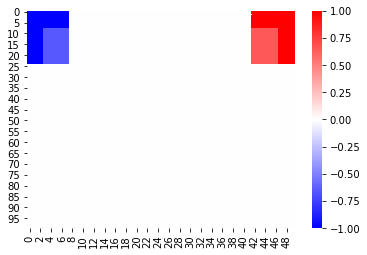

In [108]:
# create the data according to the page 1093
u_tilde = np.r_[np.array([10,9,8,7,6,5,4,3]), 2*np.ones(17), np.zeros(75)]
u = u_tilde/la.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)]
v = v_tilde/la.norm(v_tilde)
s = 50

# then, we can specify the cluster (to see how this true data looks like)
clusters = np.concatenate((np.ones(8), 2*np.ones(17), 3*np.ones(75)))
ClusterPlot(u, v, s, clusters, 0)

In [109]:
# then, according to the paper, we add some noise to the matrix

#the 'true' background X
X_star = s * u.reshape((-1,1)) @ v.reshape((-1,1)).T

# get the error matrix, and plus it to the true X
np.random.seed(663)
X = X_star + np.random.normal(0, 1, size = X_star.shape)

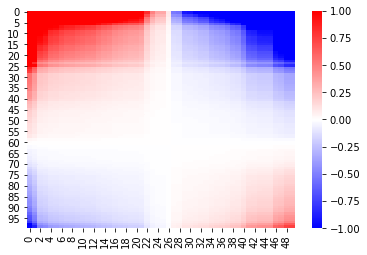

In [112]:
U, S, V = np.linalg.svd(X)
u = U.T[0]
s = S[0]
v = V.T[0]
ClusterPlot(u.reshape(-1), v.reshape(-1), s, clusters, 0)

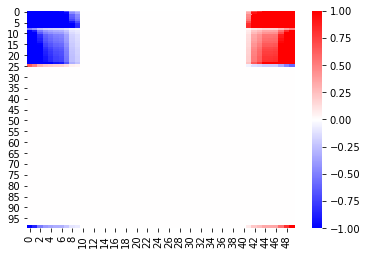

In [113]:
# apply it to our function
niter, u, v, s, _, _= SSVD(X, 2, 2)

# it performs pretty well. Almost all the noise is removed from our dataset
ClusterPlot(u.reshape(-1), v.reshape(-1), s, clusters, 0)

## Applications to real data sets

In this section, we apply the algorithm on the lung cancer data set from the original paper, and a breast cancer data set to test the performance.

### Lung Cancer Data

In the original paper, SSVD is used to identify four different cancer types and their associated subjects simultaneously. From the first plot below, we can see that the original data set is covered with lots of noise. The second plot shows the intended clusterings associated with subject numbers. After SSVD is applied, we can see that almost all the noise are removed, and the checkerboard patterns are recognized. The subjects are correctly grouped with the cancer subtypes.

In [51]:
lungcancer = pd.read_csv('LungCancerData.txt', sep=' ', header = None)
lungcancer = (np.array(lungcancer)).T
lungcancer.shape

(56, 12625)

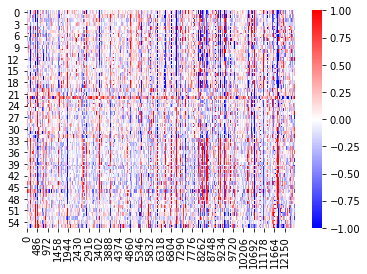

In [120]:
lungcancer = pd.read_csv('LungCancerData.txt', sep=' ', header = None)
lungcancer = (np.array(lungcancer)).T
sns.heatmap(lungcancer, vmin=-1, vmax=1, cmap = 'bwr')
pass

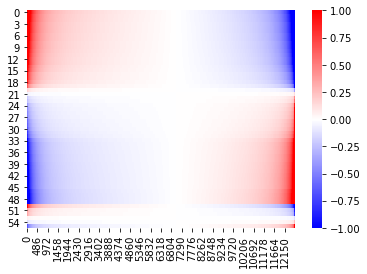

In [124]:
clusters = np.concatenate((np.ones(20), 2*np.ones(33-20), 3*np.ones(50-33), 4*np.ones(56-50)))
U, S, V = np.linalg.svd(lungcancer)
u = U.T[0]
s = S[0]
v = V.T[0]
ClusterPlot(u.reshape(-1), v.reshape(-1), s, clusters, 0)

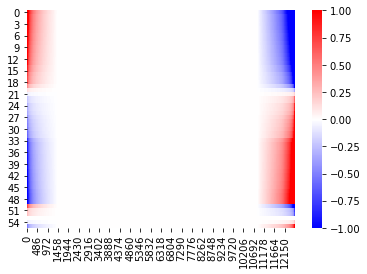

In [125]:
niter, u, v, s, _, _= SSVD(lungcancer, 2, 2)

# it performs pretty well. Almost all the noise is removed from our dataset
ClusterPlot(u.reshape(-1), v.reshape(-1), s, clusters, 0)

### Breast Cancer

We obtained the data from Classifying Breast Cancer Subtypes Using Deep Neural Networkds Based on Multi-Omics Data by Yuqi Lin, Wen Zhang, Huanshen Cao, Gaoyang Li and Wei Du. There are three subtypes of breast cancer and a fourth subgroup indicating healthy status. 

Subjects 1-30 belongs to subtype 1, 31-50 belongs to subtype 2, 51-65 belongs to subtype 3, and the rest belongs to subtype 4. The original data set looks really messy. But after applying SSVD, we can clearly recognize the checkerboard pattern, which shows four main separated areas with relative subject numbers. Thus, the algorithm successfully identifies the four status with associated to their subjects.

In [295]:
brac = pd.read_csv('bracsample.txt', sep = " ")
brac

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ABO,ABR,ABRA,ABT1,ABTB1,ABTB2,ACAA1,ACAA2,ACACA,ACACB
lminalA,0.0199,0.0148,0.0146,0.0146,0.0272,0.0158,0.0146,0.0162,0.0158,0.0158,...,0.0156,0.0150,0.0173,0.0155,0.0158,0.0163,0.0158,0.0151,0.0150,0.0162
lminalA.1,0.0219,-0.0196,0.0346,0.0346,-0.0109,0.0388,0.0346,-0.3763,0.0388,0.0388,...,0.0313,-0.3950,0.2346,0.0323,0.0388,0.0333,0.0388,0.0290,0.0248,-0.3763
lminalA.2,0.1721,0.2012,0.2308,0.2308,-0.0430,-0.0304,0.2296,-0.3297,-0.0304,-0.0304,...,-0.0360,-0.3376,0.2022,-0.0477,-0.0304,-0.0352,-0.3253,-0.0301,-0.0466,-0.3297
lminalA.3,0.0033,0.0022,0.0108,0.0108,-0.1758,-0.0032,0.0108,0.0108,-0.0032,-0.0032,...,0.0020,0.0191,0.6962,-0.0019,-0.0032,-0.0048,-0.0032,-0.0033,0.0191,0.0108
lminalA.4,0.0243,-0.0073,-0.0050,-0.0050,0.0442,0.3254,0.0124,0.0282,0.2957,0.2957,...,0.0325,-0.3592,0.3042,0.0159,0.3254,0.0033,0.0340,0.0255,0.3066,0.0245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
normal.107,0.2809,-0.1594,0.0219,0.0219,-0.1804,-0.1491,-0.1624,-0.1612,-0.1491,-0.1491,...,-0.0312,-0.1583,0.0348,0.4682,-0.1491,0.1423,-0.1491,0.1903,-0.1583,-0.1612
normal.108,0.0023,-0.0002,-0.0023,-0.0023,-0.0004,-0.0012,-0.0023,-0.0023,-0.0012,-0.0012,...,0.0008,-0.0006,0.0005,0.0001,-0.0012,-0.0001,-0.0012,0.0087,-0.0006,-0.0023
normal.109,0.0091,0.0001,-0.0124,-0.0124,-0.0632,0.0000,-0.0215,-0.0432,0.0267,0.0267,...,-0.0393,-0.0409,0.0864,-0.0238,0.0000,-0.0050,0.0198,0.0004,-0.0335,-0.0107
normal.110,0.0136,-0.0001,-0.0021,-0.0021,0.0125,-0.0038,-0.0021,-0.0020,-0.0038,-0.0038,...,0.0002,0.0083,-0.0054,-0.0050,-0.0038,-0.0018,-0.0038,-0.0018,0.0083,-0.0020


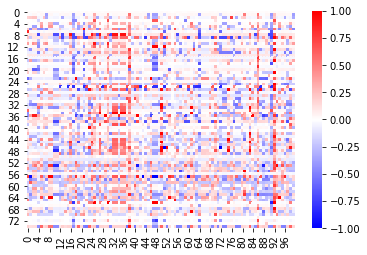

In [296]:
# look at the original data, it's pretty messy.
brac = np.array(brac)
sns.heatmap(brac, vmin=-1, vmax=1, cmap = 'bwr')
pass

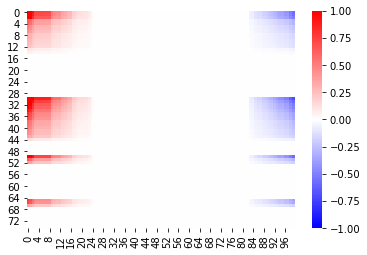

In [300]:
niter, u, v, s, _, _= SSVD(brac, 2, 2, tol = 1e-06)

# defining the clusters
clusters = np.concatenate((np.ones(30), 2*np.ones(20), 3*np.ones(15), 4*np.ones(10)))
# it performs pretty well. Almost all the noise is removed from our dataset
ClusterPlot(u.reshape(-1), v.reshape(-1), s, clusters, 0)

#aftering the SSVD, the heatmap becomes much more tidy. And we can almost successfully classify them.
#except for the very small stratums, we almost classify all of them.

## Comparative Analysis

In this section, we compare SSVD to two other algorithms for biclustering. We first apply standard singular value decomposition, and then apply sparse PCA, on the simulated data set used in Applications to Simulated Data Set section. We summarize and compare the performances of SSVD, SVD and sparse PCA in a table. From the table, we can see that SSVD and SPCA both perform well in predicting the zero loadings of $\boldsymbol u$, $\boldsymbol v$, and $\mathbf X$, but SVD performs poorly.

### Simulated data

In [ ]:
u_tilde = np.r_[np.array([10,9,8,7,6,5,4,3]), 2*np.ones(17), np.zeros(75)]
u = u_tilde/la.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)]
v = v_tilde/la.norm(v_tilde)
clusters = np.concatenate((np.ones(8), 2*np.ones(17), 3*np.ones(75)))

#the 'true' background X
X_star = s * u.reshape((-1,1)) @ v.reshape((-1,1)).T

# get the error matrix, and plus it to the true X
np.random.seed(663)
X = X_star + np.random.normal(0, 1, size = X_star.shape)

In [257]:
table = np.ones((4,3))

### SVD

In [154]:
# 1. using the svd
U, S, V = np.linalg.svd(X)
u_svd = U.T[0]
s_svd = S[0]
v_svd = V.T[0]
u_svd_acc = np.sum(u_svd == u)/u_svd.shape[0]
v_svd_acc = np.sum(v_svd == v)/v_svd.shape[0]
X_svd = s_svd * u_svd.reshape((-1,1)) @ v_svd.reshape((-1,1)).T
svd_acc = np.sum(np.round(X_svd,2) == X_star) / (u_svd.shape[0] * v_svd.shape[0])

In [258]:
table[0,0] = u_svd_acc
table[0,1] = v_svd_acc
table[0,2] = svd_acc

### SSVD

In [ ]:
# 2. apply it to our function SSVD
_, u_ssvd, v_ssvd, s_ssvd, _, _= SSVD(X, 2, 2, tol = 1e-06)

In [236]:
u_ssvd_acc = np.sum(u_ssvd.reshape(-1) == u)/u_ssvd.shape[0]
v_ssvd_acc = np.sum(v_ssvd.reshape(-1) == v)/v_ssvd.shape[0]
X_ssvd = s_ssvd * u_ssvd.reshape((-1,1)) @ v_ssvd.reshape((-1,1)).T
ssvd_acc = np.sum(np.round(X_ssvd,2) == X_star) / (u_ssvd.shape[0] * v_ssvd.shape[0])

In [259]:
table[1,0] = u_ssvd_acc
table[1,1] = v_ssvd_acc
table[1,2] = ssvd_acc

### sparse PCA
For sparse PCA, we choose $\alpha = 1$ and $\alpha = 5$.

In [260]:
#3. using the spca
from sklearn.decomposition import SparsePCA

spca = SparsePCA(max_iter=100, tol=1e-06, n_components = 1, alpha = 5)
spca.fit(X)
v_spca = spca.components_[0]
spca.fit(X.T)
u_spca = spca.components_[0]

In [261]:
u_spca_acc = np.sum(u_spca == u)/u_spca.shape[0]
v_spca_acc = np.sum(v_spca == v)/v_spca.shape[0]
X_spca = u_spca.reshape((-1,1)) @ v_spca.reshape((-1,1)).T
spca_acc = np.sum(np.round(X_spca,2) == X_star) / (u_spca.shape[0] * v_spca.shape[0])

In [262]:
table[2,0] = u_spca_acc
table[2,1] = v_spca_acc
table[2,2] = spca_acc

In [263]:
#using the spca
spca = SparsePCA(max_iter=100, tol=1e-06, n_components = 1, alpha = 1)
spca.fit(X)
v_spca = spca.components_[0]
spca.fit(X.T)
u_spca = spca.components_[0]

In [264]:
u_spca_acc = np.sum(u_spca == u)/u_spca.shape[0]
v_spca_acc = np.sum(v_spca == v)/v_spca.shape[0]
X_spca = u_spca.reshape((-1,1)) @ v_spca.reshape((-1,1)).T
spca_acc = np.sum(np.round(X_spca,2) == X_star) / (u_spca.shape[0] * v_spca.shape[0])

In [265]:
table[3,0] = u_spca_acc
table[3,1] = v_spca_acc
table[3,2] = spca_acc

In [268]:
df = pd.DataFrame(table)
df.columns = ['Accuracy for u', 'Accuracy for v', 'Accuracy for X']
df['Method'] = ['SVD', 'SSVD','SPCA (with alpha = 5)', 'SPCA (with alpha = 1)']
df

,Accuracy for u,Accuracy for v,Accuracy for X,Method
0,0.00,0.00,0.0764,SVD
1,0.74,0.68,0.9168,SSVD
2,0.75,0.68,0.9200,SPCA (with alpha = 5)
3,0.52,0.46,0.9196,SPCA (with alpha = 1)


## Conclusion and Discussion

SSVD modifies SVD with penalized regression to obtain sparse singular vectors for lower rank approximation to identify checkerboard patterns that are important for HDLSS data sets. As the sparsity automatically chooses important rows and columns, it addresses the potential interactions in the data, and therefore can be used as a nice tool for biclustering. 

We've seen the applications and performance of SSVD on two real world data sets. However, this algorithm leaves great potential directions for further study. First of all, the paper chooses adaptive lasso penalty as the sparsity-inducing penalty. We can explore other kinds of penalties that may be used for obtaining sparse singular vectors. Possible choices can be elastic net penalty, adaptive grouping penalty, and OSCAR penalty, etc. Secondly, as we no longer have iid samples in biclustering problems, we may want to develop similar asymptotic results for SSVD.

## References

Lee, Mihee, et al. "Biclustering via sparse singular value decomposition." Biometrics 66.4 (2010): 1087-1095.

Chen, Yongdong, and Qinghua Huang. "An approach based on biclustering and neural network for classification of lesions in breast ultrasound." 2016 International Conference on Advanced Robotics and Mechatronics (ICARM). IEEE, 2016.

Lin, Yuqi, et al. "Classifying Breast Cancer Subtypes Using Deep Neural Networks Based on Multi-Omics Data." Genes 11.8 (2020): 888.